In [9]:
import torch
from model import AlexNet_generate_chatgpt,AlexNet


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd

import torchvision
from torchvision.datasets import FashionMNIST

import numpy as np
import torch.utils.data as Data
import matplotlib.pyplot as plt
import time
import copy

## FashionMNIST
+ https://github.com/zalandoresearch/fashion-mnist
+ 10 lables: 
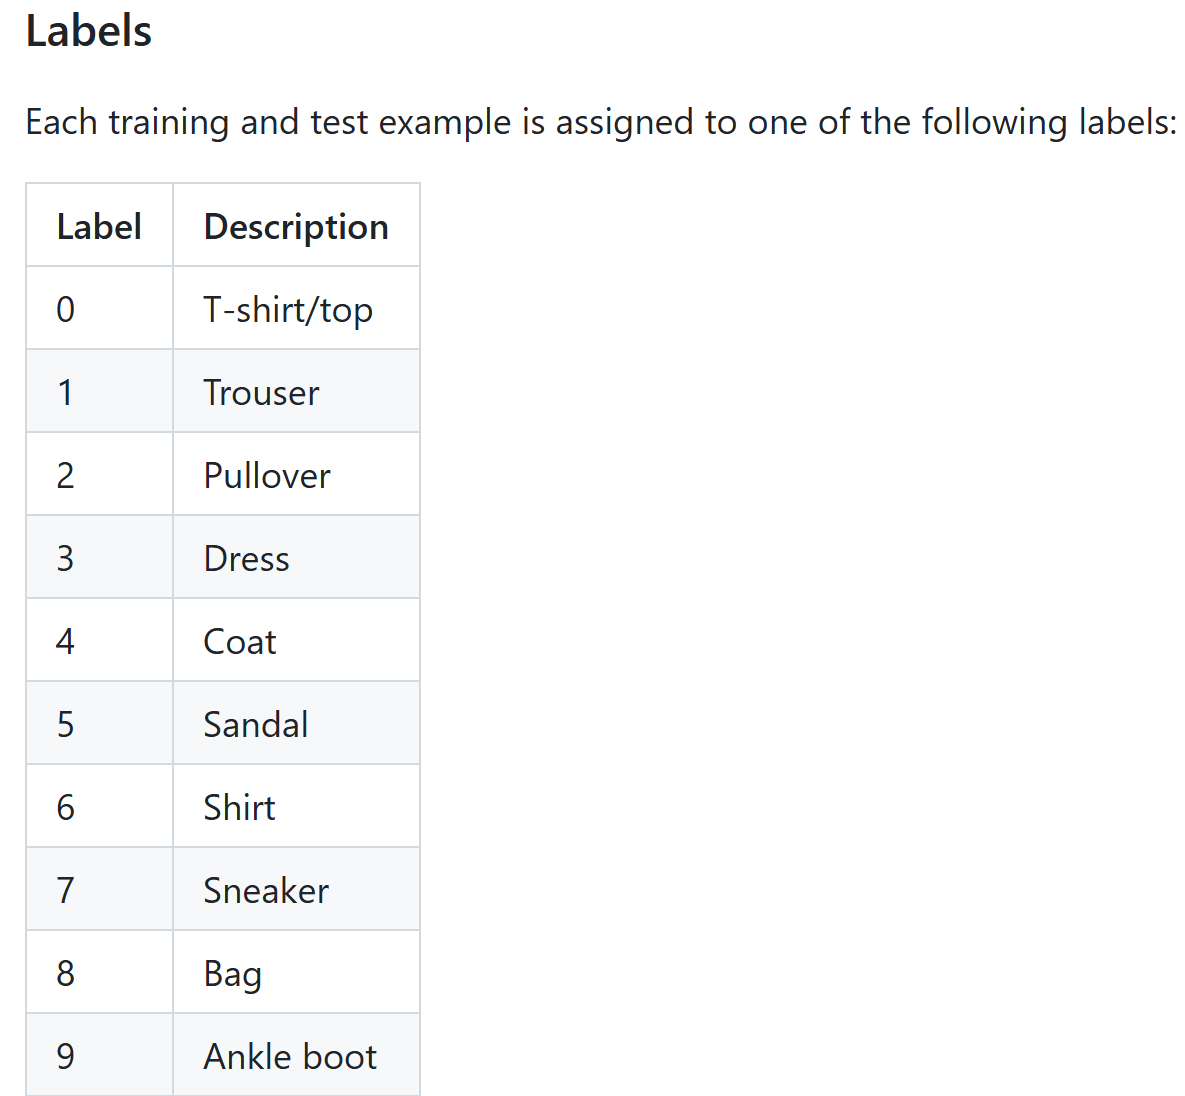 
+ 


In [ ]:
def train_val_data_process():
    train_data = FashionMNIST(root='./data', 
                          train=True, 
                          download=True, 
                          transform=transforms.Compose([transforms.Resize(size=227),transforms.ToTensor()]))  # tips:the size for different models is different
    train_data, val_data = torch.utils.data.random_split(train_data,[round(0.8*len(train_data)),round(0.2*len(train_data))])
    
    train_dataloader = Data.DataLoader(dataset = train_data, 
                                       batch_size=64, 
                                       shuffle=True, 
                                       num_workers=8)
    val_dataloader = Data.DataLoader(dataset = val_data, 
                                     batch_size=64, 
                                     shuffle=True, 
                                     num_workers=8)
    # Inspect dataset details
    print(f"Total number of training samples: {len(train_data)}")
    print(f"Total number of validation samples: {len(val_data)}")
    
    return train_dataloader, val_dataloader,train_data, val_data

In [ ]:
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')  # Remove channel dimension for grayscale
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Display some samples from the training dataset
print("Sample images from the training set:")

show_samples(train_data)

+ loss function : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
+ optimise: [SGD]: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

In [10]:
def train_model_process(model,train_dataloader,val_dataloader,num_epochs):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use GPU if available
    print(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # learning rate and weight decay
    
    
    criterion = nn.CrossEntropyLoss() # loss function
    
    model = model.to(device) # move model to GPU
    
    best_model_wts = copy.deepcopy(model.state_dict()) # copy the model weights
    
    
    # initialize the metrics
    best_acc = 0.0
    #the lost parameters list of validation dataset 
    train_loss_all = [] 
    val_loss_all   = []
    
    train_acc_all = []
    val_acc_all   = []
    
    since = time.time()



    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch,num_epochs-1))
        print("-"*10)
        
        # initialize the parameters like the loss and correct of training and validation data set
        train_loss = 0
        train_corrects = 0 
        
        val_loss = 0
        val_corrects = 0 
        
        
        train_num = 0 # the number of training data set
        val_num = 0 # the number of validation data set
        
        # to train each mini-batch
        for step,(b_x,b_y) in enumerate(train_dataloader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            
            
            model.train()
            
            output = model(b_x) # forwards computation
            pre_lab = torch.argmax(output,dim=1) # get the labels
            
            loss = criterion(output,b_y) # the loss for one batch
            
            
            # 将梯度初始化为0
            optimizer.zero_grad()
            # 反向传播计算
            loss.backward()
            # 根据网络反响传播的梯度信息来更新网络的参数，以起到降低LOSS函数计算值的作用
            optimizer.step() # update the parameters
            #对损失函数进行累加
            train_loss += loss.item() * b_x.size(0)
            #如果预测正确，则准确值 +1
            train_corrects += torch.sum(pre_lab == b_y.data)
            # 当前累积参与训练的样本量
            train_num += b_x.size(0) # 取第一维的数值，代表数据样本数量？
            
            
            
        # for evaluation 
        
            
        for step,(b_x,b_y) in enumerate(val_dataloader):
            
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            
            
            model.eval()
            output = model(b_x)
            pre_lab = torch.argmax(output,dim=1) 
            
            
            loss = criterion(output,b_y)  #tips: 验证过程只计算结果，不参与前向传播，所以验证阶段就不算
            # 对损失函数进行累加
            val_loss += loss.item() * b_x.size(0)
            # 如果预测正确，则
            val_corrects += torch.sum(pre_lab == b_y.data) #累加
            
            val_num += b_x.size(0)
            
        # 计算并保存每一次迭代的loss值和 accuracy
            
        train_loss_all.append(train_loss /train_num) #一直都在累加的loss值/总样本量
        train_acc_all.append(train_corrects.double().item()/train_num)
        
        
        val_loss_all.append(val_loss /val_num) #一直都在累加的loss值/总样本量
        val_acc_all.append(val_corrects.double().item()/val_num)    
        
        print("{} Train Loss:{:.4f} Train Acc:{:.4f}".format(epoch,train_loss_all[-1], train_acc_all[-1]))
        print("{} Val   Loss:{:.4f} Val   Acc:{:.4f}".format(epoch,val_loss_all[-1],   val_acc_all[-1]))
        
        
        # 寻找最高准确度的权重
        if val_acc_all[-1] > best_acc:
            # 保存当前的最高准确度
            best_acc = val_acc_all[-1]
             # 保存当前的模型的参数
            best_model_wts = copy.deepcopy(model.state_dict())
            
        # the time consumption for one epoch
        time_use = time.time() - since
        print("train and validation time consumption:{:.0f}m{:.0f}s".format(time_use//60,time_use%60))
        
        # select the best parameters
        # load the best parameters with the best accuracy
    # model.load_state_dict(best_model_wts)
    
    
    torch.save(best_model_wts,f"E:/code/GitHub/leetcode/Leetcode_practise/simple_model_trian_evaluate/best_model.pth") #.pth are weights file
    
        
        
    train_process = pd.DataFrame(data ={"epoch":range(num_epochs),
                                            "train_loss_all":train_loss_all,
                                            "val_loss_all":val_loss_all,
                                            "train_acc_all":train_acc_all,
                                            "val_acc_all":val_acc_all,})
        
    return train_process

In [6]:
def matplot_acc_loss(train_process):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_process["epoch"],train_process.train_loss_all,"ro-",label = "train_loss")
    plt.plot(train_process["epoch"],train_process.val_loss_all,"bs-",label = "val_loss")   
    plt.legend()
    plt.xlabel("epoch")        
    plt.ylabel("loss")
    
    
    plt.subplot(1,2,2)
    plt.plot(train_process["epoch"],train_process.train_acc_all,"ro-",label = "train_acc")
    plt.plot(train_process["epoch"],train_process.val_acc_all,"bs-",label = "val_acc")   
    plt.legend()
    plt.xlabel("epoch")        
    plt.ylabel("acc")
    
    plt.legend()
    plt.show()

In [12]:
import torch
print("Is CUDA available? ", torch.cuda.is_available())
print("CUDA Device Count: ", torch.cuda.device_count())
print("Current CUDA Device: ", torch.cuda.current_device())
print("CUDA Device Name: ", torch.cuda.get_device_name(0))  # Name of the GPU


Is CUDA available?  False
CUDA Device Count:  0


AssertionError: Torch not compiled with CUDA enabled

In [11]:
AlexNet = AlexNet_generate_chatgpt(10)
train_dataloader,val_dataloader = train_val_data_process()
train_process = train_model_process(AlexNet,train_dataloader,val_dataloader,num_epochs=3)
matplot_acc_loss(train_process)

cpu
Epoch 0/2
----------


RuntimeError: Given groups=1, weight of size [64, 3, 11, 11], expected input[64, 1, 227, 227] to have 3 channels, but got 1 channels instead